In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as la
from scipy.stats import iqr
import csv
import pandas as pd 

In [3]:
class Real_Data_JSE:
    'class for running PCA and JSE estimation for real data  '

    def __init__(self, Y):
        self.numAssets = Y.shape[0] # maximum number of assets in the experiment
        self.numPeriods = Y.shape[1] # length of sample (days)        
        self.returnsMatrix = np.array(Y)

    # end def __init__
     # compute h, sp2, lp2, h_JSE, SVD(C) from live data
    def ComputeEigensJSEC(self):
        N = self.numPeriods
        p = self.numAssets
        Y = self.returnsMatrix
        W = Y/np.sqrt(N)
        Sdual = np.matmul(W.transpose(),W)
        evalues, evectors = la.eigh(Sdual)  # Sdual a sym matrix of size n = NumPeriods
        chi = evectors[:, N - 1]  # normalized evector corr. to largest evalue of Sdual
        sp2 = evalues[N - 1]  # leading evalue of S or Sdual
        lp2 = (np.sum(evalues)-sp2)/(N -1) # average of the lesser nonzero evalues of S and Sdual
        h = np.matmul(W, chi)/np.sqrt(sp2)  # leading e-vector of S
        #h_norm = la.norm(h)
        q = np.ones(p)
        if np.dot(h,q) < 0:   # assumes b has positive mean
            h = -h
            #shrink h towards q
        gg=np.dot(h,q)/np.dot(q,q)
        h_q = np.multiply(q, gg)
        denom = np.matmul((h-h_q).transpose(), h-h_q)  # |h - h_C|^2
        if denom ==  0:
            print("ComputeJSE error: h lies in C ")
        elif denom == 1:
            print("ComputeJSE error: h is orthogonal to C ")
        c_JSE = 1 - ((lp2/sp2)/denom)   # JSE constant
        print('c_JSE is ', c_JSE)
        H1 = h_q + np.multiply(h-h_q, c_JSE)  # convex combination of h and h_C
        #H1 = np.multiply(h, 1-c_JSE) + np.multiply(h_q, c_JSE)
        h_JSE = (1/la.norm(H1))*H1
    
        return h, sp2, lp2, h_JSE

    #get k and the value h_k where where h_k is the highest beta in the lomng only portfolio
    def threshold(self, v, eta2, delta2):
         '''
            This gives the number (k) of assets in the long only portfolio and the highest beta of assets in the portfolio, 
            i.e every asset i with b_i leq beta_k is in the portfolio
         '''
         v_index= sorted(range(len(v)), key=lambda k: v[k])
         v_sorted=np.sort(v)
         if type(delta2) is np.float64:
             kappa2 = delta2/eta2
         else:
             kappa2 = 1/eta2
             delta2_sorted = [0 for i in range(len(v))]
             for i in range(len(v)):
                 delta2_sorted[i] = delta2[v_index[i]]
         r= [0 for i in range(self.numAssets)]
         r[0] = kappa2
         th= r[0]
         
         for i in range(1, self.numAssets):
             su = 0
             j = 0
             while(j< i):
                 if type(delta2) is np.float64:
                     su=su + v_sorted[j]*(v_sorted[j]-v_sorted[i])
                 else:
                     su=su + ((v_sorted[j]/delta2_sorted[j])*(v_sorted[j]-v_sorted[i]))
                 j+=1
             r[i]= kappa2+su
             th = r[i]
             k=i+1
             if th <0:
                 print('r[',i,'] is ',r[i])
                 k=k-1
                 print('k =', k)
                 break
                 #print('r[',i,'] is ',r[i])
             #print('k is', k)
             #print('v[k] is ',v_sorted[k-1])
         return k, v_sorted[k-1]

    #getting the long short portfolio
    def explicit_solution_long_short(self, v, eta2, delta2):
        '''
        This gives w_v and minimum variance using w_v and sigma_v where v is the eigenvector you choose to use, 
        eta2 and delta2 are your choice as well.
        '''
       
       
       
        one = np.ones(len(v))
        print(type(delta2))
        if type(delta2) is np.float64:
            
            
            sigma = eta2*(np.outer(v,v)) + delta2*(np.identity(len(v)))
        else:
           sigma = eta2*(np.outer(v,v)) + np.diag(delta2) 
        sigma_inv =np.linalg.inv(sigma)
        w= np.dot(sigma_inv,one )/np.dot(np.array(one),np.dot(sigma_inv, one))
        #min_var= np.dot(np.array(w),np.dot(sigma, w))
        return w

    #get the long only portfolio
    def explicit_solution(self, v, eta2, delta2):
        '''
        This gives w_v and minimum variance using w_v and sigma_v where v is the eigenvector you choose to use, 
        eta2 and elta2 are your choice as well.
        '''
        k,v_k =self.threshold(v, eta2, delta2)
        #print('k is ', k)
        removedv=[]
        reducedv=[]
        reduced_delta =[]
        for vi in v:
            if vi>v_k:
                removedv.append(np.where(v==vi)[0][0])
        for vi in v:
            if vi<=v_k:
                reducedv.append(vi)
                reduced_delta.append(delta2[np.where(v==vi)[0][0]])


        #w= self.explicit_solution_long_short( v, eta2, delta2)
        w= self.explicit_solution_long_short(reducedv, eta2, reduced_delta)
        for i in removedv:
            w=np.insert(w, i, 0)
        
        return k, w

    #get sigma_h for a particular h
    def get_sigma(self, h, sp2, lp2):
        return (sp2-lp2)*(np.outer(h,h)) + ((self.numPeriods/self.numAssets)*lp2)*(np.identity(self.numAssets))


    #get the min_var for the h
    def est_min_var(self, h, sp2, lp2, w_h):
        sigma_h = self.get_sigma(h, sp2, lp2)
        est_min_var = np.dot(np.array(w_h),np.dot(sigma_h, w_h))
        return est_min_var

    def get_ind_delta(self, eta2, h):
        N = self.numPeriods
        p = self.numAssets
        Y = self.returnsMatrix
        W = Y/np.sqrt(N)
        S = np.matmul(W,W.transpose())
        #get the individual indosyncratic risk
        delta = [0 for i in range(p)]
        for i in range(p):
            delta[i] = S[i][i]-(eta2*((h[i])**2))
        return delta

In [4]:
df = pd.read_csv('my_stock_data_cleaned_centered.csv', header=None)
dates = pd.to_datetime(df.iloc[0, 1:])
stocks_df = df.iloc[1:].copy()
stocks_df.columns = ['stock_info'] + list(dates)


stocks_df[['name', 'market_cap']] = stocks_df['stock_info'].str.extract(r'\(([^,]+),\s*([^)]+)\)')
stocks_df['market_cap'] = stocks_df['market_cap'].astype(float)


stocks_df.set_index('name', inplace=True)
stocks_df = stocks_df.iloc[0:1001,0:128]
stocks_df = pd.concat([stocks_df.iloc[0:998], stocks_df.iloc[999:1001]])
returns = stocks_df[list(dates)].apply(pd.to_numeric)
weights = stocks_df['market_cap'] / stocks_df['market_cap'].sum()
weighted_returns = returns.mul(weights, axis=0).sum(axis=0)
index_level = 100 * (1 + weighted_returns).cumprod()


index_df = pd.DataFrame({'Index': index_level}, index=dates)
Y=np.matrix(returns)
Y=np.array(Y)

In [5]:
rdy = Real_Data_JSE(Y)
h, sp2, lp2, h_JSE = rdy.ComputeEigensJSEC()
theta= np.arccos((sp2-lp2)/sp2)
print('theta is ', theta)
eta2 = sp2-lp2
delta_jse = rdy.get_ind_delta(eta2, h_JSE)
delta_jse = np.array(delta_jse)

c_JSE is  0.9648733190724618
theta is  0.14433983598134867


In [6]:
cov_JSE = eta2*(np.outer(h_JSE,h_JSE)) + np.diag(delta_jse)

In [7]:
w_M = weights.values  

# σ_M² = w_M' Ω w_M
sigma_M2 = np.dot(w_M.T, np.dot(cov_JSE, w_M))

# β = (Ω w_M) / σ_M²
beta = np.dot(cov_JSE, w_M) / sigma_M2

# idiosyncratic variances
# σ_ε² = Diag(Ω) - β σ_M²
idiosyncratic_var = np.diag(cov_JSE) - ((beta**2) * sigma_M2)

In [8]:
k_jse,w_jse = rdy.explicit_solution(beta, sigma_M2, idiosyncratic_var)
w_lsjse=rdy.explicit_solution_long_short(beta, sigma_M2, idiosyncratic_var)

r[ 65 ] is  -54.00194968578489
k = 65
<class 'list'>
<class 'numpy.ndarray'>


In [37]:
k_tjse,w_tjse = rdy.explicit_solution(h_JSE, eta2, delta_jse)
w_lstjse=rdy.explicit_solution_long_short(h_JSE, eta2, delta_jse)

r[ 66 ] is  -0.032887729906188046
k = 66
<class 'list'>
<class 'numpy.ndarray'>


In [58]:
np.max(w_jse) *100

np.float64(5.809629771890516)

0.0002279778874736152
1.0839231588903566


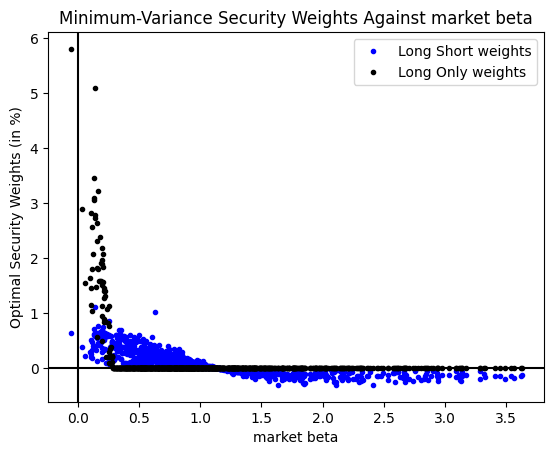

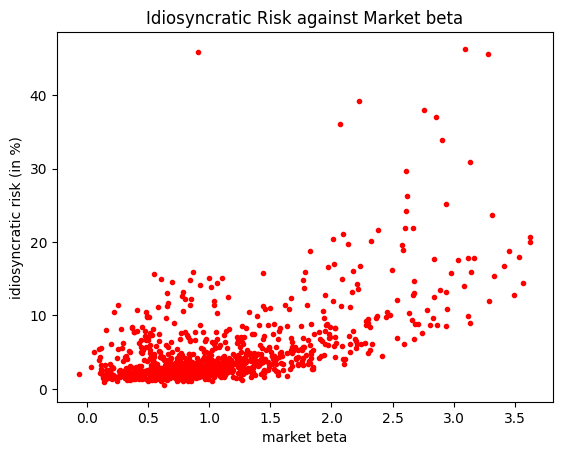

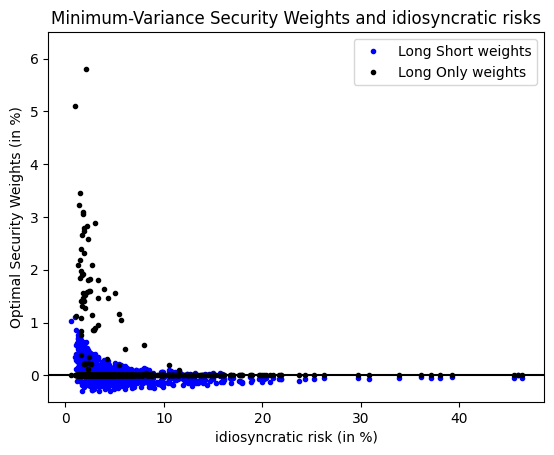

In [16]:
print(sigma_M2)
print(np.mean(beta))
plt.plot(beta, w_lsjse*100, 'b.', label = 'Long Short weights')
plt.plot(beta, w_jse*100, '.', color = '0', label = 'Long Only weights')
#plt.ylim(-0.5, 6.5)
plt.axhline(y=0, color ='k')
plt.axvline(x=0, color='k')
#plt.axvline(x=0.3, color='green', ls=':')
plt.ylabel('Optimal Security Weights (in %)')
plt.xlabel('market beta')
plt.legend(loc = 'upper right')
plt.title('Minimum-Variance Security Weights Against market beta')
plt.savefig('jj6')
plt.show()

#idiosyncratic against market beta
plt.plot(beta, idiosyncratic_var*10000, 'r.')
#plt.ylim(-0.0001, 0.002)
#plt.axhline(y=0, color ='k')
#plt.axvline(x=0, color='k')
plt.ylabel('idiosyncratic risk (in %)')
plt.xlabel('market beta')
#plt.legend(loc = 'upper right')
plt.title('Idiosyncratic Risk against Market beta')
plt.savefig('jj5')
plt.show()

#weight against idio risk
plt.plot(idiosyncratic_var*10000, w_lsjse*100, 'b.', label = 'Long Short weights')
plt.plot(idiosyncratic_var*10000, w_jse*100, '.', color = '0', label = 'Long Only weights')


plt.ylim(-0.5, 6.5)
plt.axhline(y=0, color ='k')
#plt.axvline(x=0, color='k')
plt.ylabel('Optimal Security Weights (in %)')
plt.xlabel('idiosyncratic risk (in %)')
plt.legend(loc = 'upper right')
plt.title('Minimum-Variance Security Weights and idiosyncratic risks')
plt.savefig('jj7')
plt.show()

In [39]:
#next we use the sample covariance S
N = Y.shape[1]
print(N)
W = Y/np.sqrt(N)
S = np.matmul(W,W.transpose())
# σ_M² = w_M' Ω w_M
sigma_M2_s = np.dot(w_M.T, np.dot(S, w_M))

# β = (Ω w_M) / σ_M²
beta_s = np.dot(S, w_M) / sigma_M2

# idiosyncratic variances
# σ_ε² = Diag(Ω) - β σ_M²
idiosyncratic_var_s = np.diag(S) - ((beta_s**2) * sigma_M2_s)
k_s,w_s = rdy.explicit_solution(beta_s, sigma_M2_s, idiosyncratic_var_s)
w_ls_s=rdy.explicit_solution_long_short(beta_s, sigma_M2_s, idiosyncratic_var_s)

126
r[ 51 ] is  -147.3369963019909
k = 51
<class 'list'>
<class 'numpy.ndarray'>


In [48]:
print(np.mean(beta_s))
print(sigma_M2_s)

1.1325687197593501
0.00024742467803192677


In [42]:
count=0
for i in range(len(w_tjse)):
    if w_tjse[i]>0 and w_s[i]>0:
        print(i, w_tjse[i]*100, w_s[i]*100)
        count =count+1


print(count)

6 2.2184426836939966 1.7141709593793568
11 1.0067315017688336 0.6651861209384821
20 1.3557848877269227 0.8505910677559984
23 1.4664897387705143 0.9863032891281537
26 1.9438508537619712 1.7391003197658874
39 1.1444415509458266 0.18898336609130045
41 0.8911581717066966 0.8672319898802692
55 0.8480846009110645 1.527989572248357
67 2.9184590041721585 3.6918567661300257
85 3.456325467858054 3.5567055642069363
94 0.9705220878029701 0.8619714194961038
95 2.7992262690914838 2.0858171047289034
103 1.4796683625429239 1.7277355544579296
115 3.2067538122490054 2.9056960726771908
123 0.5190287431906031 1.3942277954500086
164 1.564348787521749 2.2746544560866897
169 1.4747176590261215 0.766733966405368
173 1.5902258784853913 2.631777717141798
174 2.576824123573715 1.9343608490656299
178 1.643428255002008 1.7703868330608292
208 2.634825092125417 1.6933213133648057
238 1.046211675941048 0.47319710776720214
248 3.0398384014010045 2.8547376052161577
259 1.828993021466617 0.8423210234665391
260 3.0783360

In [1]:
'''
count=0
for i in range(len(w_tjse)):
    if w_tjse[i]>0:
        print(i, stocks_df.iloc[i]['stock_info'])
        count =count+1


print(count)
'''

"\ncount=0\nfor i in range(len(w_tjse)):\n    if w_tjse[i]>0:\n        print(i, stocks_df.iloc[i]['stock_info'])\n        count =count+1\n\n\nprint(count)\n"

In [2]:
'''
count=0
sum=0
for i in range(len(w_jse)):
    if w_jse[i]>0:
        print(i, w_jse[i]*100, stocks_df.iloc[i]['stock_info'], beta[i])
        sum = sum+w_jse[i]*100
        count =count+1


print(count)
print(sum)
'''

"\ncount=0\nsum=0\nfor i in range(len(w_jse)):\n    if w_jse[i]>0:\n        print(i, w_jse[i]*100, stocks_df.iloc[i]['stock_info'], beta[i])\n        sum = sum+w_jse[i]*100\n        count =count+1\n\n\nprint(count)\nprint(sum)\n"

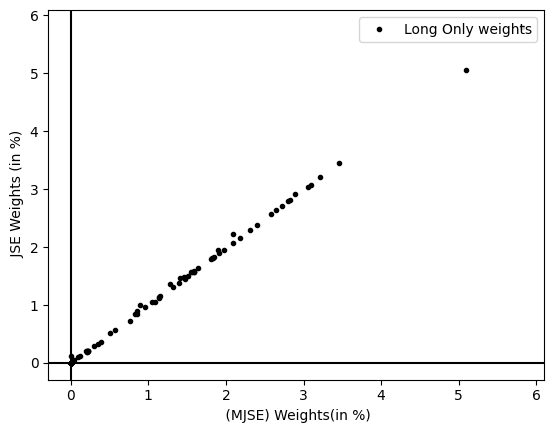

In [45]:
plt.plot(w_jse*100, w_tjse*100, '.', color = '0', label = 'Long Only weights')
#plt.ylim(-0.5, 6.5)
plt.axhline(y=0, color ='k')
plt.axvline(x=0, color='k')
plt.ylabel(' JSE Weights (in %)')
plt.xlabel(' (MJSE) Weights(in %)')
plt.legend(loc = 'upper right')
#plt.title('Scatter Plot of JSE vs MJSE optimal weights')
plt.savefig('jl')
plt.show()

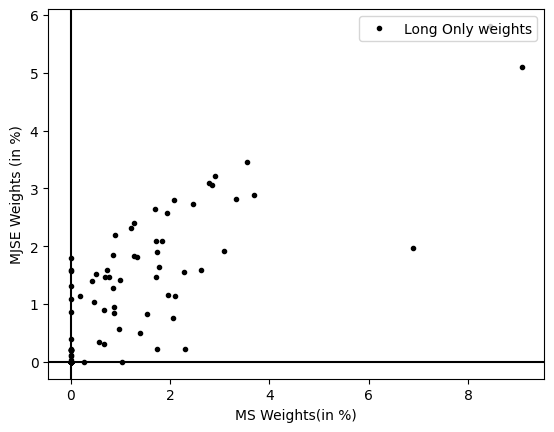

In [46]:
#scatter plots of w_s and w_jse
plt.plot(w_s*100, w_jse*100, '.', color = '0', label = 'Long Only weights')
#plt.ylim(-0.5, 6.5)
plt.axhline(y=0, color ='k')
plt.axvline(x=0, color='k')
plt.ylabel('MJSE Weights (in %)')
plt.xlabel('MS Weights(in %)')
plt.legend(loc = 'upper right')
#plt.title('Scatter Plot of MJSE vs MS optimal weights')
plt.savefig('sj')
plt.show()